 # Presence of Heart Disease
**This notebook will explore a heart disease database collected from the University of California, Irvine Machine Learning Repository. I want to compare various machine learning algorithms as well as tune the most promising models in order to maximize the accuracy of predicting the presence of heart disease. This has various applications in the medical field of detecting patients who are mostly likely to experience a heart disease in the near future given a set of features such as age, sex, and chest pains.** 


The dataset can be found here: [UCI Machine Learning Repository - Statlog (Heart)](http://archive.ics.uci.edu/ml/heart_diseases/statlog+(heart))

I will be running the following models:
1. Logistic Regression
2. Decision trees
3. K-Nearest Neighbors
4. Linear Discriminant Analysis
5. Gaussian Naive Bayes
6. Support Vector Machines

as well as have a 70/30 train/test split


In [26]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Load dataset

In [27]:
# Load heart_diseases
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat"
heart_disease = pd.read_fwf(url, header=None)
heart_disease.head()

,0,1,2,3
0,70.0,1.0,4.0,130.0 322.0 0.0 2.0 109.0 0.0 2.4 2.0 3.0 3.0 2
1,67.0,0.0,3.0,115.0 564.0 0.0 2.0 160.0 0.0 1.6 2.0 0.0 7.0 1
2,57.0,1.0,2.0,124.0 261.0 0.0 0.0 141.0 0.0 0.3 1.0 0.0 7.0 2
3,64.0,1.0,4.0,128.0 263.0 0.0 0.0 105.0 1.0 0.2 2.0 1.0 7.0 1
4,74.0,0.0,2.0,120.0 269.0 0.0 2.0 121.0 1.0 0.2 1.0 1.0 3.0 1


# Data Cleaning

Column 3 has most of our features so we split the column. Then, I create dummy binary variables for chest pain levels, ecg levels, and thalamus levels since they are categorical variables.

In [28]:
split_data =heart_disease[3].str.split('\s+', expand = True)
del heart_disease[3]
heart_disease = pd.concat([heart_disease, split_data], axis = 1, ignore_index = True)
heart_disease.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [29]:
# Store and convert categorical variables into floats
chest_pain  =heart_disease[2].astype('float64')
ecg = heart_disease[6].astype('float64')
thal = heart_disease[12].astype('float64')

# Binarize categorical variables
chest_pain_bin = pd.get_dummies(chest_pain)
ecg_bin = pd.get_dummies(ecg)
thal_bin = pd.get_dummies(thal)
response = heart_disease[13]

# Delete columns
del heart_disease[13]
del heart_disease[12]
del heart_disease[6]
del heart_disease[2]

In [16]:
heart_disease.head()

,0,1,3,4,5,7,8,9,10,11
0,70.0,1.0,130.0,322.0,0.0,109.0,0.0,2.4,2.0,3.0
1,67.0,0.0,115.0,564.0,0.0,160.0,0.0,1.6,2.0,0.0
2,57.0,1.0,124.0,261.0,0.0,141.0,0.0,0.3,1.0,0.0
3,64.0,1.0,128.0,263.0,0.0,105.0,1.0,0.2,2.0,1.0
4,74.0,0.0,120.0,269.0,0.0,121.0,1.0,0.2,1.0,1.0


In [30]:
# Mix partitioned data
heart_disease = pd.concat([heart_disease, chest_pain_bin, ecg_bin, thal_bin, response], axis = 1, ignore_index = True)

In [31]:
# Ensure quality control
heart_disease.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,70.0,1.0,130.0,322.0,0.0,109.0,0.0,2.4,2.0,3.0,...,0,0,1,0,0,1,1,0,0,2
1,67.0,0.0,115.0,564.0,0.0,160.0,0.0,1.6,2.0,0.0,...,0,1,0,0,0,1,0,0,1,1
2,57.0,1.0,124.0,261.0,0.0,141.0,0.0,0.3,1.0,0.0,...,1,0,0,1,0,0,0,0,1,2
3,64.0,1.0,128.0,263.0,0.0,105.0,1.0,0.2,2.0,1.0,...,0,0,1,1,0,0,0,0,1,1
4,74.0,0.0,120.0,269.0,0.0,121.0,1.0,0.2,1.0,1.0,...,1,0,0,0,0,1,1,0,0,1


In [32]:
heart_disease.columns

RangeIndex(start=0, stop=21, step=1)

In [33]:
heart_disease.shape

(270, 21)

In [35]:
# Look at datatypes
pd.set_option('display.max_rows',500)
heart_disease.dtypes

0     float64
1     float64
2      object
3      object
4      object
5      object
6      object
7      object
8      object
9      object
10      uint8
11      uint8
12      uint8
13      uint8
14      uint8
15      uint8
16      uint8
17      uint8
18      uint8
19      uint8
20     object
dtype: object

In [36]:
# Convert data types into float64 for arithmetic operations
heart_disease.iloc[:, 0:20] = heart_disease.iloc[:, 0:20].astype('float64')
heart_disease.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20     object
dtype: object

In [37]:
# Set precision to 3 decimal places
pd.set_option('precision', 3)
heart_disease.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000,270.000
mean,54.433,0.678,131.344,249.659,0.148,149.678,0.330,1.050,1.585,0.670,0.074,0.156,0.293,0.478,0.485,0.007,0.507,0.563,0.052,0.385
std,9.109,0.468,17.862,51.686,0.356,23.166,0.471,1.145,0.614,0.944,0.262,0.363,0.456,0.500,0.501,0.086,0.501,0.497,0.222,0.488
min,29.000,0.000,94.000,126.000,0.000,71.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,48.000,0.000,120.000,213.000,0.000,133.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,55.000,1.000,130.000,245.000,0.000,153.500,0.000,0.800,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
75%,61.000,1.000,140.000,280.000,0.000,166.000,1.000,1.600,2.000,1.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000
max,77.000,1.000,200.000,564.000,1.000,202.000,1.000,6.200,3.000,3.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Recall that we have encoded binary dummy variables. So far we have:

| Index | Column   |
|------|-----------------|
|   0  | Age|
| 1 | Sex (1-Male, 0-Female)|
|2 | Resting Blood Pressure |
|3 | Serum Cholesterol in mg/dl |
| 4 | Fasting blood sugar | 
| 5 | Maximum heart rate achieved |
| 6 | Exercise induced angina | 
| 7 | Old peak ST depression induced by exercise relative to rest |
| 8 | Slope of the peak exercise ST segment |
| 9 | Number of major vessels (0-3) colored by flourosopy |
|10 | (BINARY) Chest Pain - 1 |
| 11 | (BINARY) Chest Pain - 2 |
| 12 | (BINARY) Chest Pain - 3 |
| 13| (BINARY) Chest Pain - 4 | 
| 14 | (BINARY) Resting Electrocardiographic results - 0 |
| 15 | (BINARY) Resting Electrocardiographic results - 1 |
| 16 | (BINARY) Resting Electrocardiographic results - 2 |
| 17 | (BINARY) Thalamus: Normal (3) |
| 18 | (BINARY) Thalamus: Fixed defect (6) |
| 19 | (BINARY) Thalamus: Reversable defect ( 7) |
| 20 | Absence (1) or presence (2) of heart disease |

# Histogram Plots

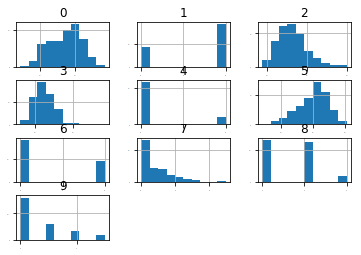

In [38]:
## Create histograms
heart_disease.hist( column = [0,1,2,3,4,5,6,7,8,9],sharex = False, sharey = False, xlabelsize = 1, ylabelsize = 1)
plt.show()

We observe that age reasonably follows a normal distribution. Also, resting blood pressure at the time the data was taken seems to follow a right skewed normal distribution. The levels of exercised induced angina also follows a right skewed normal distribution. Slope of the peak exercise ST segment is reasonably a normal distribution. Note that we have a class imbalance in sex, fasting blood sugar, number of major vessels colored by flouroscopy, and slope of the peaks.

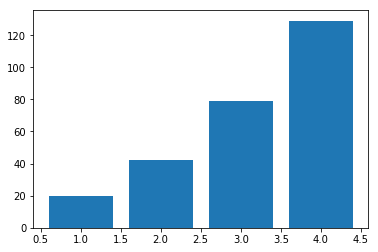

In [50]:
# Histogram based on chest pain levels
plt.bar(range(1,5),chest_pain.value_counts().sort_index())
plt.show()

In [55]:
ecg.value_counts().sort_index()

0.0    131
1.0      2
2.0    137
Name: 6, dtype: int64

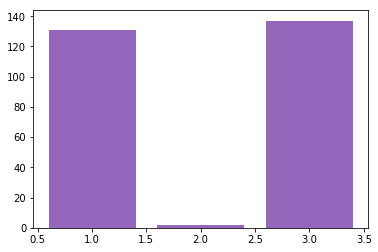

In [56]:
# Barplot based on electrocardiogram levels (0,1,2)
plt.bar(range(1,4),ecg.value_counts().sort_index())
plt.show()

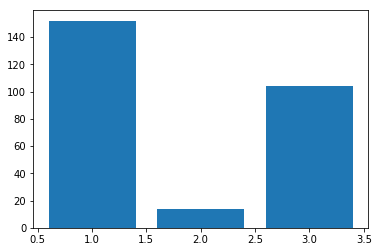

In [57]:
# Barplot based on thalamus
plt.bar(range(1,4), thal.value_counts().sort_index())
plt.show()

# Density Plots

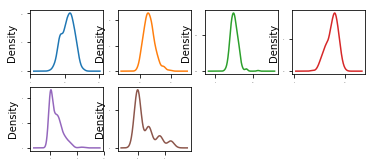

In [60]:
# Create density plots on non-binary data
heart_disease.iloc[:, [0,2,3,5,7,9]].plot(kind='density', subplots=True, layout=(3,4), sharex=False, legend=False, fontsize=1)
plt.show()

# Correlation matrix
In order to prevent the confusion between the binary variables I have encoded, I have decided to leave them off in order to see some basic relationships in the data.

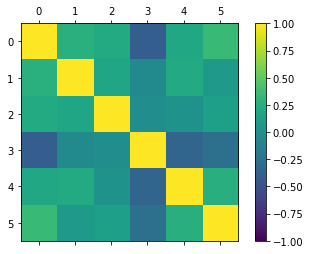

In [61]:
# See correlation between non-binary data
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(heart_disease.iloc[:, [0,2,3,5,7,9]].corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
plt.show()

# Validation dataset
I decide to have train/test split of 70/30 in order to get some reasonable results.

In [62]:
array = heart_disease.values
X = array[:,0:19].astype(float)
Y = array[:,20]
validation_size = 0.3
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,test_size=validation_size, random_state=seed)

# Evaluate Algorithms
I also perform a 15-fold cross-validation and use the accuracy of classification as my performance metric.

In [63]:
# Test options and evaluation metric
num_folds = 15
num_instances = len(X_train)
seed = 7
scoring_accuracy = 'accuracy'

In [64]:
# Store models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [65]:
# Run LR, LDA, KNN, CART, NB, SVM on data
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n = num_instances, n_folds = num_folds, random_state = seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring_accuracy)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.847009 (0.095536)
LDA: 0.831197 (0.101481)
KNN: 0.697863 (0.102774)
CART: 0.745726 (0.124094)

C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anacond


NB: 0.800000 (0.092010)
SVM: 0.544017 (0.127086)


Linear Discriminant Analysis (LDA) gives us a warning that certain predictors are collinear. This makes sense due to our binary encoding of the variables. For example, an increase in scoring a 1 on chest pain implies a decrease on chest pains of 2,3,4 and so it underestimates the effect of scoring a 1 on heart disease.

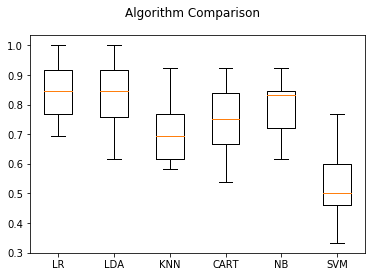

In [66]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Standardize data due to distributions
Note that variables such as age carry the most weight in the classification process and so I decide to standardize the data points to the standard normal distribution.

In [67]:
# Standardize the heart_disease
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
results = []
names = []
for name, model in pipelines:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring_accuracy)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.826068 (0.117499)
ScaledLDA: 0.831197 (0.101481)
ScaledKNN: 0.810684 (0.090560)

C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\aznch\Anacond


ScaledCART: 0.757692 (0.126055)
ScaledNB: 0.779487 (0.128094)
ScaledSVM: 0.852564 (0.067353)


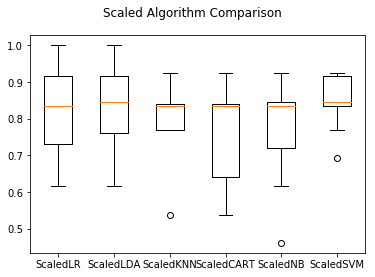

In [68]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Fine tune k Nearest neighbors
By default, k-Nearest Neighbors runs 5 neighbors so I'd like to tune the parameter to see if we can achieve better accuracy. 

In [549]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11,13,15,17,19,21]

param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring_accuracy, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
    

Best: 0.835979 using {'n_neighbors': 17}
0.745906 (0.084507) with: {'n_neighbors': 1}
0.782749 (0.101879) with: {'n_neighbors': 3}
0.820468 (0.105395) with: {'n_neighbors': 5}
0.788889 (0.104691) with: {'n_neighbors': 7}
0.804971 (0.093860) with: {'n_neighbors': 9}
0.815497 (0.105559) with: {'n_neighbors': 11}
0.815497 (0.105559) with: {'n_neighbors': 13}
0.826023 (0.112695) with: {'n_neighbors': 15}
0.836257 (0.097995) with: {'n_neighbors': 17}
0.820760 (0.113049) with: {'n_neighbors': 19}
0.825731 (0.112664) with: {'n_neighbors': 21}


# Fine tuning Logistic Regression
Logistic Regression showed us the best promise and so by changing the hyperparameter, C, I hope to achieve better accuracy as we cross-validate.

In [558]:
# Fine tune Logistic Regression
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = {'C': [.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] }
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, scoring=scoring_accuracy, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
    

Best: 0.846561 using {'C': 0.01}
0.815205 (0.102838) with: {'C': 0.0001}
0.815205 (0.102838) with: {'C': 0.001}
0.847076 (0.113728) with: {'C': 0.01}
0.841813 (0.112613) with: {'C': 0.1}
0.847076 (0.103527) with: {'C': 1}
0.841813 (0.110125) with: {'C': 10}
0.825731 (0.107634) with: {'C': 100}
0.825731 (0.107634) with: {'C': 1000}


# Fine tuning Support Vector Machine
SVM is one of those algorithms that can perform well if the kernel and hyperparameter, C, is tuned. Therefore, we perform a grid search to try various combinations.

In [545]:
# Fine tune SVM parameter c as well as kernels
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)

kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring=scoring_accuracy, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.851852 using {'C': 0.5, 'kernel': 'rbf'}
0.836257 (0.100782) with: {'C': 0.1, 'kernel': 'linear'}
0.619883 (0.122556) with: {'C': 0.1, 'kernel': 'poly'}
0.804386 (0.105121) with: {'C': 0.1, 'kernel': 'rbf'}
0.831287 (0.107036) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.830994 (0.101709) with: {'C': 0.3, 'kernel': 'linear'}
0.799708 (0.121500) with: {'C': 0.3, 'kernel': 'poly'}
0.836257 (0.100782) with: {'C': 0.3, 'kernel': 'rbf'}
0.841813 (0.102301) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.836257 (0.092168) with: {'C': 0.5, 'kernel': 'linear'}
0.820760 (0.120175) with: {'C': 0.5, 'kernel': 'poly'}
0.852047 (0.096236) with: {'C': 0.5, 'kernel': 'rbf'}
0.841813 (0.102301) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.836257 (0.092168) with: {'C': 0.7, 'kernel': 'linear'}
0.841813 (0.099557) with: {'C': 0.7, 'kernel': 'poly'}
0.846784 (0.098057) with: {'C': 0.7, 'kernel': 'rbf'}
0.847076 (0.106169) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.836257 (0.092168) with: {'C': 0.9, 'kernel': 'linear'

# Ensemble Methods

In [487]:
# Run emsemble methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring_accuracy)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.819264 (0.067595)
GBM: 0.838745 (0.078820)
RF: 0.824459 (0.072499)
ET: 0.833766 (0.049706)


# Compare Algorithms 

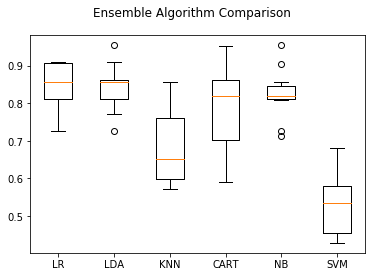

In [542]:
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Performance on the Validation Set

In [72]:
# Test LR model with C = .01
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = LogisticRegression(C=.01)
model.fit(rescaledX, Y_train)

# Test on cross validation set
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print("Logistic Regression")
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))


Logistic Regression
0.83950617284
[[40  7]
 [ 6 28]]
             precision    recall  f1-score   support

          1       0.87      0.85      0.86        47
          2       0.80      0.82      0.81        34

avg / total       0.84      0.84      0.84        81



In [71]:
# Test SVC with hyperparameter C= .03 and rbf 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model2 = SVC(C=.5, kernel = "rbf")
model2.fit(rescaledX, Y_train)
predictions2 = model2.predict(rescaledValidationX)

print("Support Vector Machine")
print(accuracy_score(Y_validation, predictions2))
print(confusion_matrix(Y_validation, predictions2))
print(classification_report(Y_validation, predictions2))

Support Vector Machine
0.827160493827
[[40  7]
 [ 7 27]]
             precision    recall  f1-score   support

          1       0.85      0.85      0.85        47
          2       0.79      0.79      0.79        34

avg / total       0.83      0.83      0.83        81

['1' '1' '1' '1' '2' '1' '2' '1' '1' '1' '1' '2' '1' '1' '1' '2' '1' '1'
 '1' '1' '1' '1' '2' '2' '2' '1' '2' '2' '1' '2' '2' '2' '1' '2' '1' '1'
 '2' '2' '2' '1' '1' '1' '2' '1' '1' '1' '2' '2' '1' '2' '2' '2' '1' '2'
 '1' '2' '1' '1' '2' '1' '1' '1' '2' '2' '1' '1' '1' '2' '1' '1' '2' '1'
 '2' '2' '1' '1' '1' '2' '1' '2' '2']


In [458]:
model3

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

In [73]:
# Test kNN with 17 neighbors
model3 =  KNeighborsClassifier(n_neighbors = 17)
model3.fit(rescaledX, Y_train)
predictions3 = model3.predict(rescaledValidationX)

print( "k-Nearest Neighbors")
print(accuracy_score(Y_validation, predictions3))
print(confusion_matrix(Y_validation, predictions3))
print(classification_report(Y_validation, predictions3))


k-Nearest Neighbors
0.827160493827
[[40  7]
 [ 7 27]]


'             precision    recall  f1-score   support\n\n          1       0.85      0.85      0.85        47\n          2       0.79      0.79      0.79        34\n\navg / total       0.83      0.83      0.83        81\n'

We conclude that by using logistic regression, we can achieve 84% accuracy in our model after fine tuning. 